<a href="https://colab.research.google.com/github/mathluva/BERT-TensorFlow/blob/main/TensorFlow_Toxic_Comments.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!nvidia-smi

Mon Mar  1 01:40:41 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.39       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from google.colab import drive
drive.mount("/GD")

Drive already mounted at /GD; to attempt to forcibly remount, call drive.mount("/GD", force_remount=True).


In [ ]:
import tensorflow as tf
print(tf.version.VERSION)

2.4.1


In [ ]:
# install requirements to use tensorflow/models repository
!pip install -Uqr models/official/requirements.txt
# you may have to restart the runtime afterwards

In [ ]:
import pandas as pd
import tensorflow as tf
import tensorflow_hub as hub
from datetime import datetime
import os

In [ ]:
import sys
sys.path.append('models')
from official.nlp.data import classifier_data_lib
from official.nlp.bert import tokenization
from official.nlp import optimization

In [ ]:
print("TF Version: ", tf.__version__)
print("Hub version: ", hub.__version__)

TF Version:  2.4.1
Hub version:  0.11.0


In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split

In [ ]:
df= pd.read_csv("/GD/My Drive/train_preprocessed.csv")

In [ ]:
rows = len(df)
print(f'There are {rows} rows')

There are 159571 rows


In [ ]:
ids = df.id.nunique()
print(f'There are {ids} unique ids')

There are 159571 unique ids


In [ ]:
#replace index with id
df.set_index('id', inplace =True) 

In [ ]:
#toxicity is total of all categories per comment
# toxicity 6 means comment was classified for all categories
df.toxicity.value_counts() 

0.0    143346
1.0      6360
3.0      4209
2.0      3480
4.0      1760
5.0       385
6.0        31
Name: toxicity, dtype: int64

In [ ]:
#keep comments with only one label
df = df[df['toxicity'].values ==1]
df

,comment_text,identity_hate,insult,obscene,set,severe_toxic,threat,toxic,toxicity
id,,,,,,,,,
0005c987bdfc9d4b,hey what is it talk what is it an exclusive ...,0.0,0.0,0.0,train,0.0,0.0,1.0,1.0
0007e25b2121310b,bye don t look come or think of comming back...,0.0,0.0,0.0,train,0.0,0.0,1.0,1.0
001956c382006abd,i m sorry i m sorry i screwed around with some...,0.0,0.0,0.0,train,0.0,0.0,1.0,1.0
002264ea4d5f2887,why can t you believe how fat artie is did yo...,0.0,0.0,0.0,train,0.0,0.0,1.0,1.0
005f59485fcddeb0,sorry puck but no one ever said dick was numb...,0.0,0.0,0.0,train,0.0,0.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...
fcf5a6ad5918f164,your boring and retard ed two,0.0,0.0,0.0,train,0.0,0.0,1.0,1.0
fd0129fde97321cb,why did that idiot revert the reversion i made...,0.0,0.0,0.0,train,0.0,0.0,1.0,1.0
fd68ef478b3dfd05,ps you re all middle aged losers at home in yo...,0.0,0.0,0.0,train,0.0,0.0,1.0,1.0


In [ ]:
#check sum of identity_hate
df.identity_hate.value_counts()

0.0    6306
1.0      54
Name: identity_hate, dtype: int64

In [ ]:
#create new column label
#decode the rows
for index, row in df.iterrows():
    if df.loc[index, 'identity_hate'] == 1:
      df.loc[index, 'label'] = 'identity_hate'

    elif df.loc[index, 'insult'] == 1:
      df.loc[index, 'label'] = 'insult'

    elif df.loc[index, 'obscene'] == 1:
      df.loc[index, 'label'] = 'obscene'

    elif df.loc[index, 'severe_toxic'] == 1:
      df.loc[index, 'label'] = 'severe_toxic'

    elif df.loc[index, 'threat'] == 1:
      df.loc[index, 'label'] = 'threat'

    else:
        df.loc[index, 'label'] = 'toxic'

In [ ]:
#create new column to hold label value
possible_lables = ['identity_hate', 'insult', 'obscene', 'severe_toxic', 'threat', 'toxic']

label_dict = {}
for index, label in enumerate(possible_lables):
    label_dict[label] = index

df['label_value'] = df.label.replace(label_dict)

In [ ]:
label_dict

{'identity_hate': 0,
 'insult': 1,
 'obscene': 2,
 'severe_toxic': 3,
 'threat': 4,
 'toxic': 5}

In [ ]:
df.tail(10)

,comment_text,identity_hate,insult,obscene,set,severe_toxic,threat,toxic,toxicity,label,label_value
id,,,,,,,,,,,
fb4cbf4eeabe23d4,study some linguistics before you say somethi...,0.0,0.0,0.0,train,0.0,0.0,1.0,1.0,toxic,5
fbb9d76ad8911cc4,the first of your links is something to agree ...,0.0,0.0,1.0,train,0.0,0.0,0.0,1.0,obscene,2
fbf8672ea3b4ddf7,http w nysun com article public interest crap,0.0,0.0,0.0,train,0.0,0.0,1.0,1.0,toxic,5
fc6d45d108129fc8,goethean and me i would like you to know i ha...,0.0,0.0,0.0,train,0.0,0.0,1.0,1.0,toxic,5
fccf0939631ab7c8,stop telling lies and trying to promote your p...,0.0,0.0,0.0,train,0.0,0.0,1.0,1.0,toxic,5
fcf5a6ad5918f164,your boring and retard ed two,0.0,0.0,0.0,train,0.0,0.0,1.0,1.0,toxic,5
fd0129fde97321cb,why did that idiot revert the reversion i made...,0.0,0.0,0.0,train,0.0,0.0,1.0,1.0,toxic,5
fd68ef478b3dfd05,ps you re all middle aged losers at home in yo...,0.0,0.0,0.0,train,0.0,0.0,1.0,1.0,toxic,5
fdc92e571d39e7e1,yeah i no it suck s,0.0,0.0,0.0,train,0.0,0.0,1.0,1.0,toxic,5


In [ ]:
#check totals
df['label'].value_counts()

toxic            5666
obscene           317
insult            301
identity_hate      54
threat             22
Name: label, dtype: int64

In [ ]:
df = df.drop(columns= ['set', 'toxicity'])
df.head()

,comment_text,identity_hate,insult,obscene,severe_toxic,threat,toxic,label,label_value
id,,,,,,,,,
0005c987bdfc9d4b,hey what is it talk what is it an exclusive ...,0.0,0.0,0.0,0.0,0.0,1.0,toxic,5
0007e25b2121310b,bye don t look come or think of comming back...,0.0,0.0,0.0,0.0,0.0,1.0,toxic,5
001956c382006abd,i m sorry i m sorry i screwed around with some...,0.0,0.0,0.0,0.0,0.0,1.0,toxic,5
002264ea4d5f2887,why can t you believe how fat artie is did yo...,0.0,0.0,0.0,0.0,0.0,1.0,toxic,5
005f59485fcddeb0,sorry puck but no one ever said dick was numb...,0.0,0.0,0.0,0.0,0.0,1.0,toxic,5


In [151]:
#create training invalid split to keep the imbalance, use stratify as target values
#train_size only using a small amount for execution time
train_df, remaining = train_test_split(df, random_state = 42, train_size= .75, stratify = df.label_value.values)

#create validation of df on remaining
#splits the remaining_df, validation set
valid_df, _ = train_test_split(remaining, random_state = 42, train_size = .99,stratify = remaining.label_value.values)


In [152]:
# 75/25 split
train_df.shape, valid_df.shape

((4770, 9), (1574, 9))

In [153]:
train_data = tf.data.Dataset.from_tensor_slices((train_df['comment_text'].values, train_df['label_value'].values))
valid_data= tf.data.Dataset.from_tensor_slices((valid_df['comment_text'].values, valid_df['label_value'].values))

#print one pair in tensorflow dataset to "take" a look at 
for text, label in train_data.take(1):
  print(text)
  print(label)

tf.Tensor(b'excuse me  i was the user who originally put that poster up onto the page only for it to get promptly  deleted  so when another user puts it on there  it stays up  i call dick on that situation', shape=(), dtype=string)
tf.Tensor(5, shape=(), dtype=int64)


In [154]:
data_column = 'comment_text'
label_column = 'label_value'
label_list = [0,1,2,3,4,5]
max_seq_length = 128 

# Get BERT layer and tokenizer:
bert_layer = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/2",
                            trainable=True)

vocab_file = vocab_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()

#use uncase version of BERT
do_lower_case = bert_layer.resolved_object.do_lower_case.numpy()

#FullTokenizer from BERT handles all the preprocessing of incoming raw text data
tokenizer = tokenization.FullTokenizer(vocab_file, do_lower_case)


**guid**: A unique id that represents an observation.

**text_a**: The text we need to classify into given categories

**text_b**: It is used when we’re training a model to understand the relationship 
between sentences and it does not apply for classification problems.

**label**: It consists of the labels or classes or categories that a given text belongs to.

In [165]:
def create_examples(df, labels_available=True):
    """Creates examples for the training and dev sets."""
    examples = []
    for (i, row) in enumerate(df.values):
        guid = row[0]
        text_a = row[1]
        if labels_available:
            labels = row[2:]
        else:
            labels = [0,0,0,0,0,0]
        examples.append(
            InputExample(guid=guid, text_a=text_a, labels=labels))
    return examples

In [156]:
# This provides a function to convert row to input features and label
def to_feature(examples, max_seq_length, tokenizer):
    features = []
    for (ex_index, example) in enumerate(examples):
        print(example.text_a)
        tokens_a = tokenizer.tokenize(example.text_a)

        tokens_b = None
        if example.text_b:
            tokens_b = tokenizer.tokenize(example.text_b)
            # Modifies `tokens_a` and `tokens_b` in place so that the total
            # length is less than the specified length.
            # Account for [CLS], [SEP], [SEP] with "- 3"
            _truncate_seq_pair(tokens_a, tokens_b, max_seq_length - 3)
        else:
            # Account for [CLS] and [SEP] with "- 2"
            if len(tokens_a) > max_seq_length - 2:
                tokens_a = tokens_a[:(max_seq_length - 2)]


        tokens = ["[CLS]"] + tokens_a + ["[SEP]"]
        segment_ids = [0] * len(tokens)

        if tokens_b:
            tokens += tokens_b + ["[SEP]"]
            segment_ids += [1] * (len(tokens_b) + 1)

        input_ids = tokenizer.convert_tokens_to_ids(tokens)

        # The mask has 1 for real tokens and 0 for padding tokens. Only real
        # tokens are attended to.
        input_mask = [1] * len(input_ids)

        # Zero-pad up to the sequence length.
        padding = [0] * (max_seq_length - len(input_ids))
        input_ids += padding
        input_mask += padding
        segment_ids += padding

        assert len(input_ids) == max_seq_length
        assert len(input_mask) == max_seq_length
        assert len(segment_ids) == max_seq_length
        
        labels_ids = []
        for label in example.labels:
            labels_ids.append(int(label))
        
      if ex_index < 0:
            logger.info("*** Example ***")
            logger.info("guid: %s" % (example.guid))
            logger.info("tokens: %s" % " ".join(
                    [str(x) for x in tokens]))
            logger.info("input_ids: %s" % " ".join([str(x) for x in input_ids]))
            logger.info("input_mask: %s" % " ".join([str(x) for x in input_mask]))
            logger.info(
                    "segment_ids: %s" % " ".join([str(x) for x in segment_ids]))
            logger.info("label: %s (id = %s)" % (example.labels, labels_ids))

        features.append(
                InputFeatures(input_ids=input_ids,
                              input_mask=input_mask,
                              segment_ids=segment_ids,
                              label_ids=labels_ids))
    return features


In [166]:
def to_feature_map(text, label):
  #wrapping to_feature function, input is text, label, tensor output is int32 -create one for each
  input_ids, input_mask, segment_ids, label_id = tf.py_function(to_feature, inp = [text, label], Tout = [tf.int32,tf.int32, tf.int32, tf.int32])

  #create padding for constant sequence length
  input_ids.set_shape(max_seq_length)
  input_mask.set_shape(max_seq_length)
  segment_ids.set_shape(max_seq_length)
  label_id.set_shape([]) #can leave blank

  #bundle features into dictionary
  x = { 'input_word_ids': input_ids,
       'input_mask': input_mask,
       'input_type_ids': segment_ids
       }
  
  return (x, label_id)


In [167]:
with tf.device('/cpu:0'):
  # train, transforming original train_data using the function and  wrapper created by mapping 
  #map applies user defined function to each element of the input data set, because they are independent they can be done parallel
  #AUTOTUNE allows tf to determing the optimal size for // calls
  #prefetch data ahead of time without waiting for current
 
  train_data = (train_data.map(to_feature_map, num_parallel_calls = tf.data.experimental.AUTOTUNE).shuffle(1000)
  .batch(32, drop_remainder = True)
  .prefetch(tf.data.experimental.AUTOTUNE))

  # valid, do everything except shuffling
  valid_data = (valid_data.map(to_feature_map, num_parallel_calls = tf.data.experimental.AUTOTUNE)
  .batch(32, drop_remainder = True)
  .prefetch( tf.data.experimental.AUTOTUNE))
  

TypeError: ignored

In [159]:
# train data spec
train_data.element_spec

({'input_mask': TensorSpec(shape=(32, 128), dtype=tf.int32, name=None),
  'input_type_ids': TensorSpec(shape=(32, 128), dtype=tf.int32, name=None),
  'input_word_ids': TensorSpec(shape=(32, 128), dtype=tf.int32, name=None)},
 TensorSpec(shape=(32,), dtype=tf.int32, name=None))

In [160]:
# valid data spec
valid_data.element_spec

({'input_mask': TensorSpec(shape=(32, 128), dtype=tf.int32, name=None),
  'input_type_ids': TensorSpec(shape=(32, 128), dtype=tf.int32, name=None),
  'input_word_ids': TensorSpec(shape=(32, 128), dtype=tf.int32, name=None)},
 TensorSpec(shape=(32,), dtype=tf.int32, name=None))

In [161]:
def create_model():


  input_word_ids = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32,
                                       name="input_word_ids")
  input_mask = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32,
                                   name="input_mask")
  #segment_id from doc
  input_type_ids = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32,
                                    name="input_type_ids")
  pooled_output, sequence_output = bert_layer([input_word_ids, input_mask, input_type_ids])

  drop = tf.keras.layers.Dropout(0.4)(pooled_output) #hyperparameter, add dropout regularization
  output = tf.keras.layers.Dense(1, activation = 'sigmoid', name = 'output')(drop) # sigmoid for probability
  model = tf.keras.Model(
     inputs ={
         'input_word_ids': input_word_ids,
       'input_mask': input_mask,
       'input_type_ids': input_type_ids
       },
       outputs = output)
  return model
  

In [162]:
model = create_model()
model.compile(optimizer = tf.keras.optimizers.Adam(),
              loss = 'categorical_crossentropy',
              metrics =[tf.keras.metrics.CategoricalCrossentropy()])
model.summary()

Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_word_ids (InputLayer)     [(None, 128)]        0                                            
__________________________________________________________________________________________________
input_mask (InputLayer)         [(None, 128)]        0                                            
__________________________________________________________________________________________________
input_type_ids (InputLayer)     [(None, 128)]        0                                            
__________________________________________________________________________________________________
keras_layer_3 (KerasLayer)      [(None, 768), (None, 109482241   input_word_ids[0][0]             
                                                                 input_mask[0][0]           

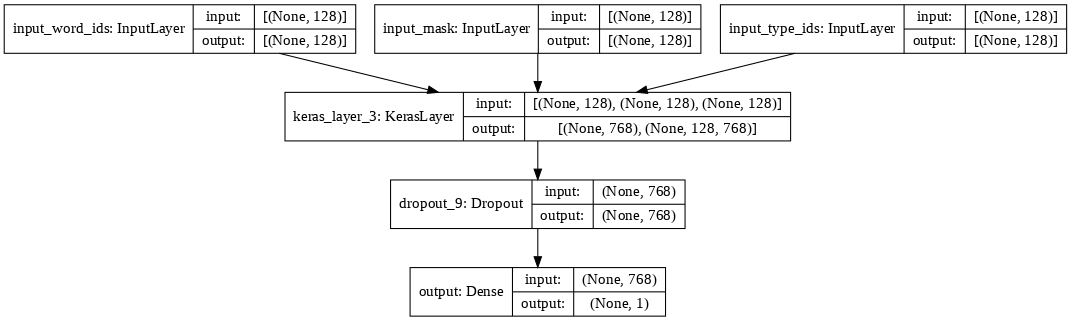

In [163]:

tf.keras.utils.plot_model(model = model, show_shapes=True, dpi = 76)

In [164]:
epochs = 5
history = model.fit(train_data, validation_data= valid_data, epochs = epochs, verbose =1)

Epoch 1/5


UnknownError: ignored

In [ ]:
def accuracy_per_class(preds, labels):
    label_dict_inverse = {v: k for k, v in label_dict.items()}
    
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()

    for label in np.unique(labels_flat):
        y_preds = preds_flat[labels_flat==label]
        y_true = labels_flat[labels_flat==label]
        print(f'Class: {label_dict_inverse[label]}')
        print(f'Accuracy: {len(y_preds[y_preds==label])}/{len(y_true)}\n')

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

In [ ]:
model_save_name = 'classifierII.pt'
path = F"/content/gdrive/My Drive/{model_save_name}" 
torch.save(model.state_dict(), path)